# Titanic     

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold

sns.set_theme(style='white', context='notebook', palette='coolwarm')


## Carregameto dos Dados

In [124]:
# Carrega os Dados

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
IDtest = test["PassengerId"]

In [125]:
print(f"Shape do conjunto de treino: {train.shape}")
print(f"Shape do conjunto de teste: {test.shape}")

Shape do conjunto de treino: (891, 12)
Shape do conjunto de teste: (418, 11)


In [126]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [127]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [128]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Detecção de Outliers

In [129]:
def detect_outliers(df, n, features):
    """
    Recebe um dataframe df com as variáveis e retorna uma lista dos índices  
    correspondentes às observações que contêm mais de n outliers de acordo  
    com o método de Tukey.
    """
    outlier_indices = []
    
    # Iterar sobre as variáveis (colunas)
    for col in features:
        # 1º quartil (25%)
        Q1 = np.percentile(df[col], 25)
        # 3º quartil (75%)
        Q3 = np.percentile(df[col], 75)
        # Intervalo interquartil (IQR)
        IQR = Q3 - Q1
        
        # Passo para identificação de outliers
        outlier_step = 1.5 * IQR
        
        # Determinar uma lista de índices dos outliers para a variável col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # Adicionar os índices dos outliers encontrados para col à lista de índices de outliers
        outlier_indices.extend(outlier_list_col)
        
    # Selecionar observações que contêm mais de n outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = [k for k, v in outlier_indices.items() if v > n]
    
    return multiple_outliers   

# Detecta outliers nas variáveis Age, SibSp, Parch e Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

Outliers podem prejudicar modelos de machine learning porque distorcem a média, afetam a variância, causam overfitting e influenciam algoritmos baseados em distância e gradiente. Para lidar com eles, podemos removê-los.

Para detectar os outliers, vamos usar o método Tukey, considerando como outlier as amostras com pelo menos duas váriaveis outliers.

In [130]:
train.loc[Outliers_to_drop] # Mostra as amostras outliers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [131]:
# Dropa outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [132]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### Procurando null e valores faltantes

In [133]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age e Cabin possuem muitos valores faltando!

## Análise Exploratória de Dados

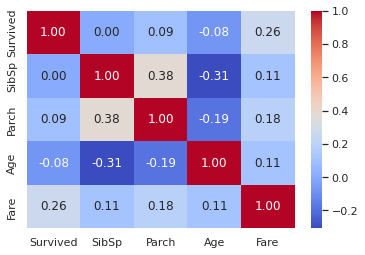

In [134]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Apenas a variável Fare parece ter uma correlação significativa com a probabilidade de sobrevivência.

Isso não significa que as outras variáveis não sejam úteis. Algumas subpopulações dentro dessas variáveis podem estar correlacionadas com a sobrevivência. Para determinar isso, precisamos explorar essas variáveis em mais detalhes.

#### SibSP

* SibSp (Siblings/Spouses) indica o número de irmãos (siblings) e cônjuges (spouses) que um passageiro tinha a bordo.

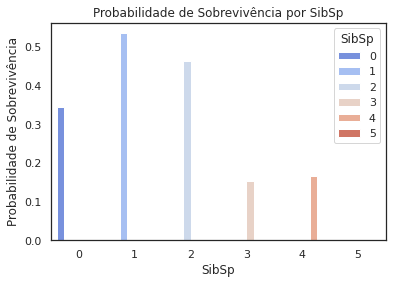

In [135]:
survived_sibsp = train.groupby('SibSp')['Survived'].mean().reset_index()
g = sns.barplot(x='SibSp', y='Survived', data=survived_sibsp, hue="SibSp", palette='coolwarm')
g.set_ylabel('Probabilidade de Sobrevivência')
g.set_xlabel('SibSp')
g.set_title('Probabilidade de Sobrevivência por SibSp')
plt.show()

Parece que passageiros com muitos irmãos/cônjuges têm menos chances de sobreviver.

Passageiros que viajaram sozinhos (SibSp = 0) ou acompanhados por até duas pessoas (SibSp = 1 ou 2) têm mais chances de sobreviver.

#### Parch

* Parch (Parents/Children) indica o número de pais ou filhos que um passageiro tinha a bordo. Se for 0, significa que a pessoa viajava sozinha, sem pais ou filhos.

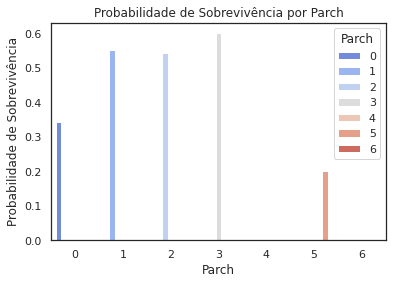

In [136]:
survived_parch = train.groupby('Parch')['Survived'].mean().reset_index()
g = sns.barplot(x='Parch', y='Survived', data=survived_parch, hue='Parch', palette='coolwarm')
g.set_ylabel('Probabilidade de Sobrevivência')
g.set_xlabel('Parch')
g.set_title('Probabilidade de Sobrevivência por Parch')
plt.show()

Parece que famílias pequenas tiveram mais chance de sobreviver!

Pessoas sem pais ou filhos provavelmente não tiveram muita ajuda e famílias grandes podem ter se preocupado demais com os demais familiares.

#### Age

/home/guilherme/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/guilherme/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


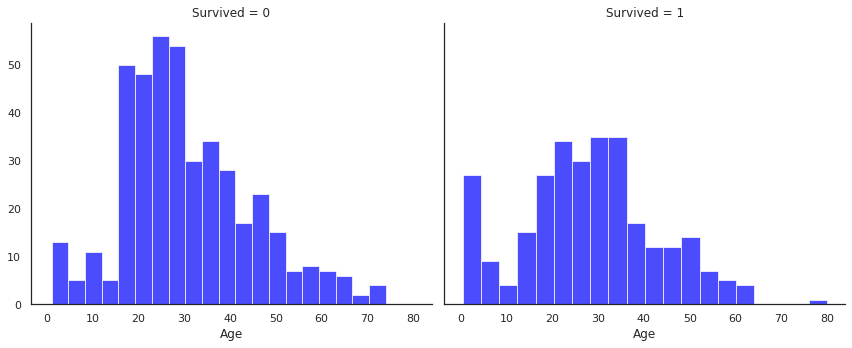

In [137]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived', palette='coolwarm', height=5, aspect=1.2)
g.map(plt.hist, "Age", bins=20, color="blue", alpha=0.7)

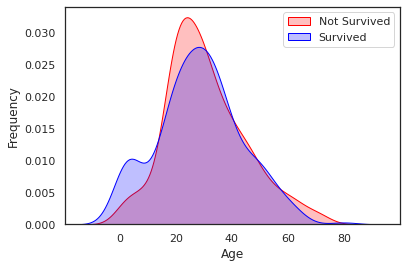

In [138]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", fill = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", fill= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Percebemos que as distribuições de idade não são as mesmas entre as subpopulações de sobreviventes e não sobreviventes. De fato, há um pico correspondente a passageiros jovens que sobreviveram. Também observamos que passageiros entre 60 e 80 anos tiveram menor taxa de sobrevivência.

Portanto, mesmo que "Age" não esteja fortemente correlacionada com "Survived", podemos notar que certas faixas etárias têm mais ou menos chances de sobreviver.

Parece que passageiros muito jovens têm maiores chances de sobreviver.

#### Fare

In [139]:
dataset["Fare"].isnull().sum()

1

* Vamos tratar o valor faltante de Fare. Como é apenas uma amostra, vamos apesar usar a mediana.

In [140]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

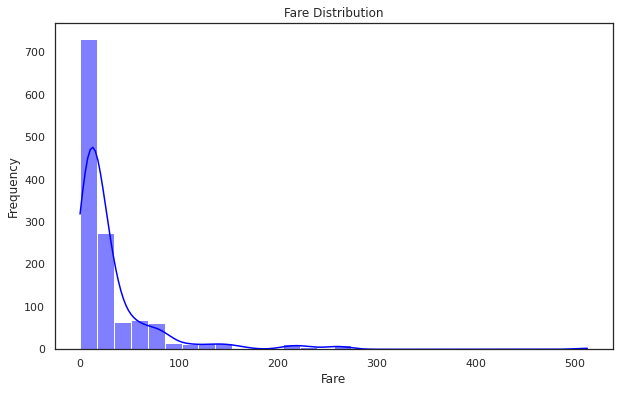

In [141]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset['Fare'], kde=True, color='blue', bins=30)
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

Como podemos ver, a distribuição da variável Fare é muito distorcida. Isso pode fazer com que valores muito altos tenham um peso exagerado no modelo, mesmo após a normalização.

Nesse caso, é melhor aplicar a transformação logarítmica para reduzir essa distorção.

In [142]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

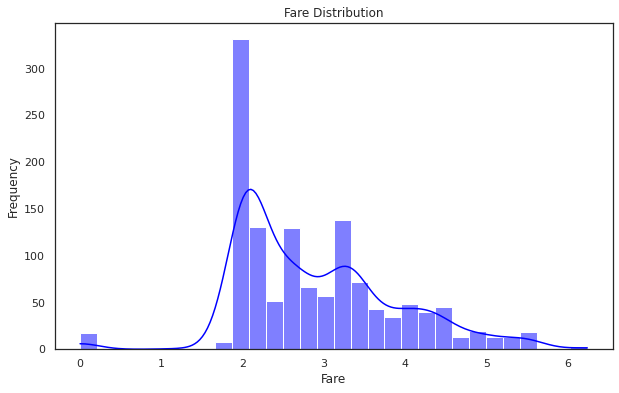

In [143]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset['Fare'], kde=True, color='blue', bins=30)
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

### Features Categóricas
#### Sex

/home/guilherme/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/guilherme/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


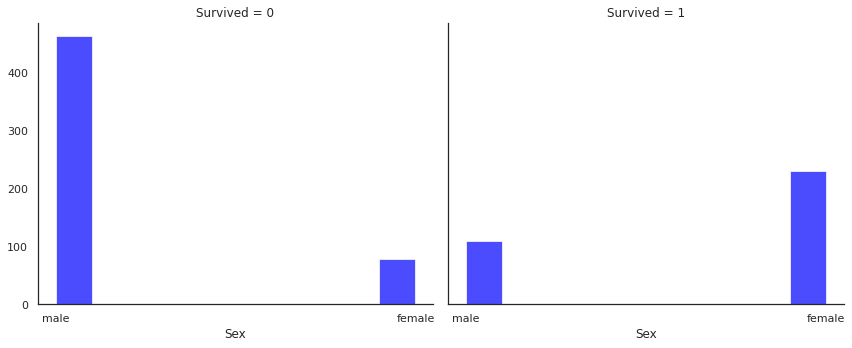

In [144]:
g = sns.FacetGrid(train, col='Survived', palette='coolwarm', height=5, aspect=1.2)
g.map(plt.hist, "Sex", color="blue", alpha=0.7)

Homens tiveram menos chances de sobrevivência.

"Women and children first". 

#### Pclass
Representa a classe da passagem do passageiro. Ela indica a categoria socioeconômica em que o passageiro estava viajando. 

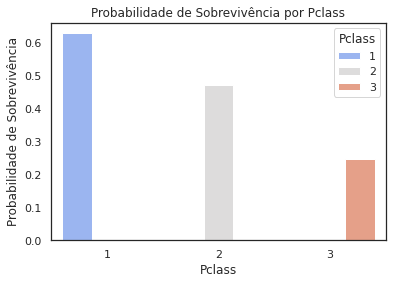

In [145]:
survived_pclass = train.groupby('Pclass')['Survived'].mean().reset_index()
g = sns.barplot(x='Pclass', y='Survived', data=survived_pclass, hue='Pclass', palette='coolwarm')
g.set_ylabel('Probabilidade de Sobrevivência')
g.set_xlabel('Pclass')
g.set_title('Probabilidade de Sobrevivência por Pclass')
plt.show()

Passageiros da primeira e segunda classe tiveram mais chance de sobrevivência do que paassageiros da terceira classe.

#### Embarked
Representa o porto de embarque do passageiro.

* C = Cherbourg (França)

* Q = Queenstown (atual Cobh, Irlanda)

* S = Southampton (Inglaterra)

In [146]:
dataset["Embarked"].isnull().sum()

2

* Vamos tratar os valores faltante. Como são apenas duas amostra, vamos apesar usar o valor mais frequente.

In [147]:
dataset["Embarked"] = dataset["Embarked"].fillna(dataset["Embarked"].mode())

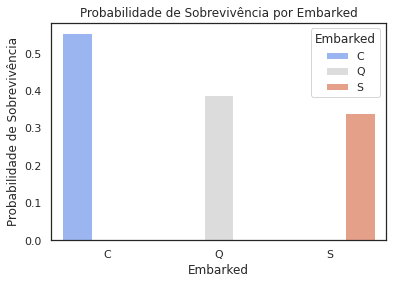

In [148]:
survived_embarked = train.groupby('Embarked')['Survived'].mean().reset_index()
g = sns.barplot(x='Embarked', y='Survived', data=survived_embarked, hue='Embarked', palette='coolwarm')
g.set_ylabel('Probabilidade de Sobrevivência')
g.set_xlabel('Embarked')
g.set_title('Probabilidade de Sobrevivência por Embarked')
plt.show()

Passageiros que embarcaram na França tiveram mais chances de sobreviver.

Uma hipótese é que o pessoal que embarcou na França estavam majoritariamente na primeira e segunda classe.

Vamos ver a distribuição de Embarked contra Pclass

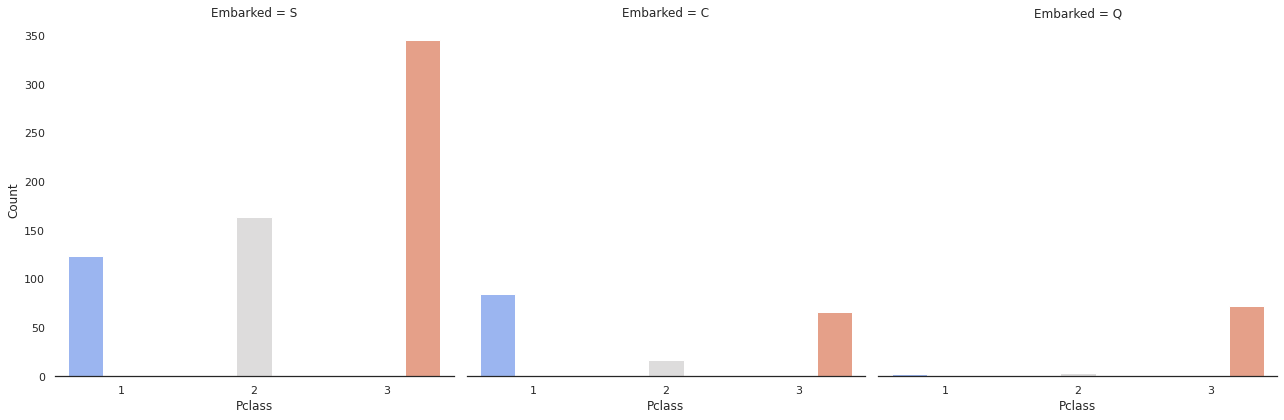

In [149]:
# Explore Pclass vs Embarked 
g = sns.catplot(x="Pclass", col="Embarked", data=train,
                height=6, kind="count", hue="Pclass",palette="coolwarm")
g.despine(left=True)
g.set_ylabels("Count")
plt.show()

## Preenchendo Valores Faltantes
### Age

Como podemos ver, a coluna Age contém 256 valores ausentes em todo o conjunto de dados.

Como vimos, parece haver subpopulações com maior chance de sobrevivência (como crianças, por exemplo), é preferível manter a variável Age e imputar os valores ausentes.

Para resolver esse problema, vamos analisar as variáveis mais correlacionadas com Age: Sex, Parch, Pclass e SibSP.

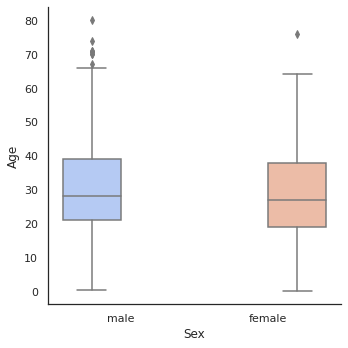

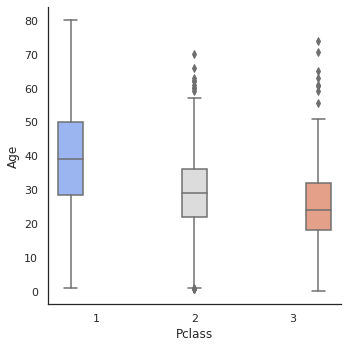

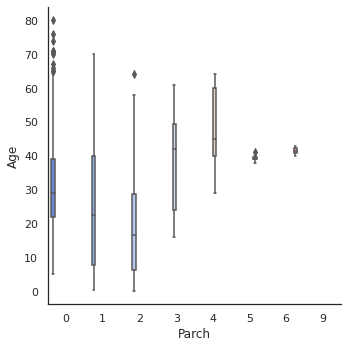

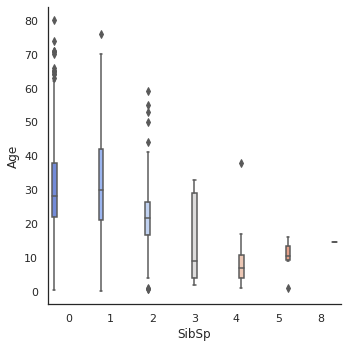

In [150]:
g = sns.catplot(y="Age", x="Sex", data=dataset, kind="box", palette='coolwarm', hue="Sex")
g = sns.catplot(y="Age", x="Pclass", data=dataset, kind="box", palette='coolwarm', hue="Pclass")
g = sns.catplot(y="Age", x="Parch", data=dataset, kind="box", palette='coolwarm', hue="Parch")
g = sns.catplot(y="Age", x="SibSp", data=dataset, kind="box", palette='coolwarm', hue="SibSp")

A distribuição da idade parece ser a mesma entre as subpopulações masculinas e femininas, portanto, Sex não é uma variável informativa para prever Age.

No entanto, passageiros da 1ª classe são mais velhos do que os da 2ª classe, que, por sua vez, são mais velhos do que os da 3ª classe.

Além disso, quanto mais pais/filhos um passageiro tem, mais velho ele tende a ser, enquanto quanto mais irmãos/cônjuges ele tem, mais jovem ele tende a ser.

Então, vamos usar SibSP, Parch e Pclass para imputar as idades ausentes.

A estratégia consiste em preencher Age com a mediana da idade de linhas semelhantes, de acordo com Pclass, Parch e SibSP.

In [151]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

In [152]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)
age_med = dataset["Age"].median()

for i in index_NaN_age :
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & 
                               (dataset['Parch'] == dataset.iloc[i]["Parch"]) & 
                               (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    dataset.loc[i, 'Age'] = age_pred if not np.isnan(age_pred) else age_med

## Engenharia de Features
### Name/Title

In [153]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

A variável Name contém informações sobre o título dos passageiros.

Como alguns passageiros com títulos distintos podem ter sido priorizados durante a evacuação, é interessante adicionar essa informação ao modelo.

In [154]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

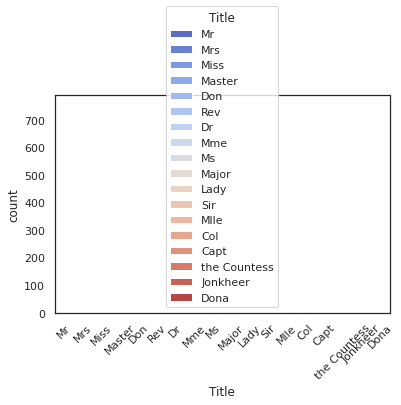

In [155]:
g = sns.countplot(x="Title",data=dataset, hue="Title",palette="coolwarm")
g = plt.setp(g.get_xticklabels(), rotation=45) 

Existem muitos títulos. Vamos agrupar alguns deles.

In [156]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

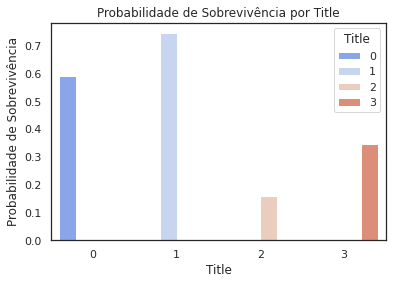

In [157]:
survived_title = dataset.groupby('Title')['Survived'].mean().reset_index()
g = sns.barplot(x='Title', y='Survived', data=survived_title, hue='Title', palette='coolwarm')
g.set_ylabel('Probabilidade de Sobrevivência')
g.set_xlabel('Title')
g.set_title('Probabilidade de Sobrevivência por Title')
plt.show()

In [158]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

In [159]:
dataset.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,C,1
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,S,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,S,2


 Como a idade importa muito 'woman and children first' iremos mapear a idade em intervalos, afim de enfatizar essa idéia.

In [160]:
dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
dataset.loc[dataset['Age'] > 64, 'Age'] = 4  
dataset.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,0,1.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1.0,1,1,2.0,1,0,PC 17599,4.266662,C85,C,1
2,3,1.0,3,1,1.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1.0,1,1,2.0,1,0,113803,3.972177,C123,S,1
4,5,0.0,3,0,2.0,0,0,373450,2.085672,NaN,S,2


Iremos criar um novo atributo, family size, combinando parch e SibSp

In [161]:
dataset['Family Size'] = dataset['Parch'] + dataset['SibSp']

Além disso, criaremos um atributo para verificar se ele está sozinho ou não

In [162]:
alone = []

for qtd in dataset['Family Size']:
    if(qtd == 0):
        alone.append(1)
    else:
        alone.append(0)
        
dataset['Is Alone'] = alone

Tentativa usando o ticket

In [163]:
dataset = dataset.drop(columns=['Cabin', 'Ticket', 'Parch', 'SibSp'])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [164]:
dataset

,PassengerId,Survived,Pclass,Sex,Age,Fare,Title,Family Size,Is Alone,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1.0,1.981001,2,1,0,0,0,1
1,2,1.0,1,1,2.0,4.266662,1,1,0,1,0,0
2,3,1.0,3,1,1.0,2.070022,1,0,1,0,0,1
3,4,1.0,1,1,2.0,3.972177,1,1,0,0,0,1
4,5,0.0,3,0,2.0,2.085672,2,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,3,0,1.0,2.085672,2,0,1,0,0,1
1295,1306,NaN,1,1,2.0,4.690430,3,0,1,1,0,0
1296,1307,NaN,3,0,2.0,1.981001,2,0,1,0,0,1
1297,1308,NaN,3,0,1.0,2.085672,2,0,1,0,0,1


In [165]:
## Separate train dataset and test dataset

train = dataset[:train_len].copy()
test = dataset[train_len:].copy()
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [166]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

Vamos avaliar 6 classificadores usando validação cruzada:

* SVC
* Decision Tree
* Random Forest
* KNN
* Logistic regression
* XGBoost

In [167]:
kfold = StratifiedKFold(n_splits=10)

In [168]:
classifiers = []
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(xgb.XGBClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
        "CrossValMeans":cv_means,
        "CrossValerrors": cv_std,
        "Modelo":["SVC","DecisionTree", "RandomForest","KNeighboors","LogisticRegression","XGBoost"]
    })

cv_res = cv_res.sort_values('CrossValMeans', ascending=False)

/home/guilherme/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/guilherme/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [169]:
cv_res

,CrossValMeans,CrossValerrors,Modelo
4,0.818399,0.028215,LogisticRegression
2,0.808235,0.042280,RandomForest
5,0.752566,0.110118,XGBoost
1,0.709691,0.112841,DecisionTree
0,0.614070,0.001302,SVC
3,0.462028,0.082832,KNeighboors


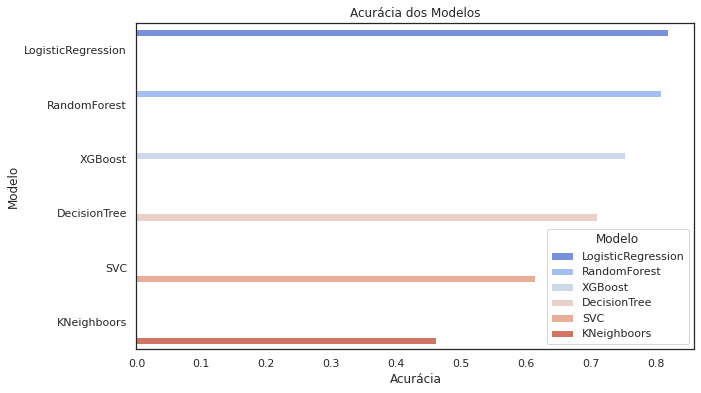

In [170]:
# Criando o gráfico de barras horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x='CrossValMeans', y='Modelo', data=cv_res, palette='coolwarm', hue='Modelo')

# Adicionando título e rótulos
plt.title('Acurácia dos Modelos')
plt.xlabel('Acurácia')
plt.ylabel('Modelo')

# Exibindo o gráfico
plt.show()

#### Otimização de Hiperparâmetros

In [171]:
import optuna
from sklearn.metrics import accuracy_score

# Função de otimização para o Optuna
def objective(trial):
    # Definir o espaço de busca para os hiperparâmetros
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 3, 50),  # profundidade máxima da árvore
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),  # taxa de aprendizado
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),  # número de estimadores
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # fração de amostras a serem usadas
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # fração de características a serem usadas
    }
    
    # Treinar o modelo XGBoost
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, Y_train)
    
    kfold = StratifiedKFold(n_splits=5)
    accuracy = cross_val_score(model, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=4)
    accuracy = accuracy.mean()
    
    return accuracy

# Criar e otimizar o estudo
study = optuna.create_study(direction='maximize')  # maximize para maximizar a acurácia
study.optimize(objective, n_trials=30)  # n_trials define o número de tentativas de otimização

# Melhor conjunto de hiperparâmetros
print("Melhores hiperparâmetros encontrados: ", study.best_params)

# Melhor resultado
print("Melhor acurácia obtida: ", study.best_value)


[I 2025-02-06 11:27:19,041] A new study created in memory with name: no-name-3895f0a9-cca9-455b-954d-b7a7ed54884d
[I 2025-02-06 11:27:19,746] Trial 0 finished with value: 0.8003787878787879 and parameters: {'max_depth': 17, 'learning_rate': 0.123170984471333, 'n_estimators': 267, 'subsample': 0.9041383942768122, 'colsample_bytree': 0.6523915788014635}. Best is trial 0 with value: 0.8003787878787879.
[I 2025-02-06 11:27:20,070] Trial 1 finished with value: 0.8026515151515152 and parameters: {'max_depth': 43, 'learning_rate': 0.08204210233154925, 'n_estimators': 106, 'subsample': 0.7506467717232225, 'colsample_bytree': 0.6930697993531153}. Best is trial 1 with value: 0.8026515151515152.
[I 2025-02-06 11:27:20,788] Trial 2 finished with value: 0.8015151515151515 and parameters: {'max_depth': 9, 'learning_rate': 0.04447713253787448, 'n_estimators': 337, 'subsample': 0.6080625089489271, 'colsample_bytree': 0.652370406604752}. Best is trial 1 with value: 0.8026515151515152.
[I 2025-02-06 11:

Melhores hiperparâmetros encontrados:  {'max_depth': 24, 'learning_rate': 0.0018278112505837898, 'n_estimators': 738, 'subsample': 0.8423024866557113, 'colsample_bytree': 0.7676804880779774}
Melhor acurácia obtida:  0.8286209553158705


### 6.3 Prediction

In [172]:
xgb_optimized = xgb.XGBClassifier(
    max_depth=37,
    learning_rate=0.006954668807737573,
    n_estimators=238,
    subsample=0.7165617187363452,
    colsample_bytree=0.956110137829175,
    objective='binary:logistic',
    eval_metric='logloss'
)
xgb_optimized.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.956110137829175, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.006954668807737573,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=37, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=238, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [173]:
test_Survived = pd.Series(xgb_optimized.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)
results.to_csv("xgb_optimized.csv",index=False)